In [78]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/aoifekenny/midterm-aoifekenny/train.csv')
test_x = pd.read_csv('/Users/aoifekenny/midterm-aoifekenny/test.csv')


Id                            0
ProductId                     0
UserId                        0
HelpfulnessNumerator          0
HelpfulnessDenominator        0
Time                          0
Summary                       1
Text                          1
Score                     17470
Helpful                   50064
dtype: int64


<Axes: >

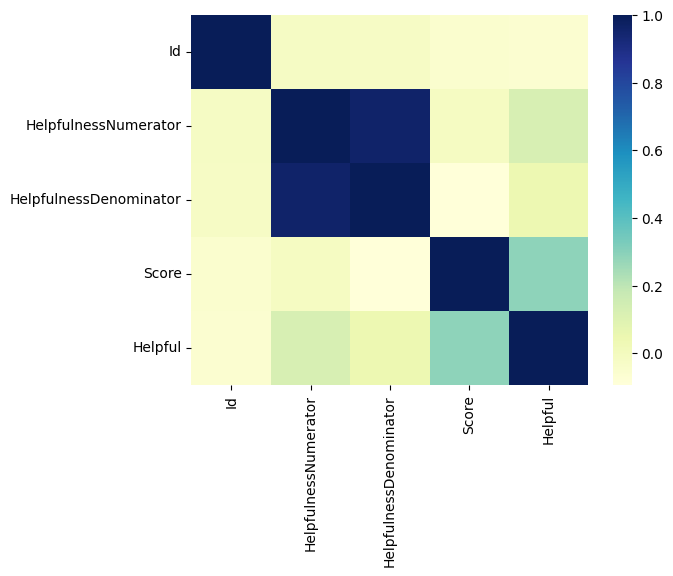

In [79]:

df['Helpful'] = df['HelpfulnessNumerator']/ df['HelpfulnessDenominator']
df['Time'] = pd.to_datetime(df['Time'], unit='s')
nan_counts = df.isna().sum()
print(nan_counts)
numeric_cols = df.select_dtypes(include=[np.number]) #select numeric cols
sns.heatmap(numeric_cols.corr(), cmap = 'YlGnBu') #correlation map between numeric features

In [80]:
df['Helpful'] = df['Helpful'].fillna(0)
df = df.dropna(subset=['Score']) #drops the rows w no score bc that's the test set
nan_counts = df.isna().sum()
print(nan_counts)

Id                        0
ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   1
Text                      1
Score                     0
Helpful                   0
dtype: int64


In [81]:
score_counts =df['Score'].value_counts()
total_vals = len(df['Score'])
probs = score_counts / total_vals
print(probs)

Score
5.0    0.534113
4.0    0.227489
3.0    0.118430
1.0    0.060196
2.0    0.059771
Name: count, dtype: float64


In [82]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english')) #creates the set of stopwords to extract from nltk lib
word_freq = {} #dictionary that will have the freq of important words grouped by score and total number of appearences
for index, row in df.iterrows():
    if isinstance(row['Text'], str):
        words = row['Text'].lower().split()
        words = [word for word in words if word not in stopwords]
        score = row['Score'] #creates a score variable for this row
        for word in words:
            if word in word_freq:
                word_freq[word][score] += 1 #increases the count for that score by 1
                word_freq[word]['total'] += 1 #counts the total # of appearences of the word
            else:
                word_freq[word] = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 'total': 0} #initializes the word in the dict
                word_freq[word][row['Score']] += 1 
                word_freq[word]['total'] += 1
sorted_freq = sorted(word_freq.items(), key=lambda x: x[1]['total'], reverse=True)
print(sorted_freq [10:20])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aoifekenny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('story', {1: 1429, 2: 2304, 3: 4912, 4: 8817, 5: 14962, 'total': 32424}), ('even', {1: 3171, 2: 2854, 3: 4446, 4: 7888, 5: 13884, 'total': 32243}), ('-', {1: 1683, 2: 2321, 3: 4542, 4: 8403, 5: 14984, 'total': 31933}), ('first', {1: 1758, 2: 2040, 3: 4286, 4: 8209, 5: 15141, 'total': 31434}), ('much', {1: 1778, 2: 2785, 3: 5544, 4: 8378, 5: 12319, 'total': 30804}), ('also', {1: 979, 2: 1531, 3: 3918, 4: 8234, 5: 14405, 'total': 29067}), ('love', {1: 895, 2: 1148, 3: 2424, 4: 5495, 5: 18203, 'total': 28165}), ('time', {1: 1690, 2: 1916, 3: 3759, 4: 6993, 5: 13202, 'total': 27560}), ('dvd', {1: 1328, 2: 1074, 3: 2699, 4: 5733, 5: 13543, 'total': 24377}), ('well', {1: 703, 2: 1111, 3: 2921, 4: 7044, 5: 12004, 'total': 23783})]


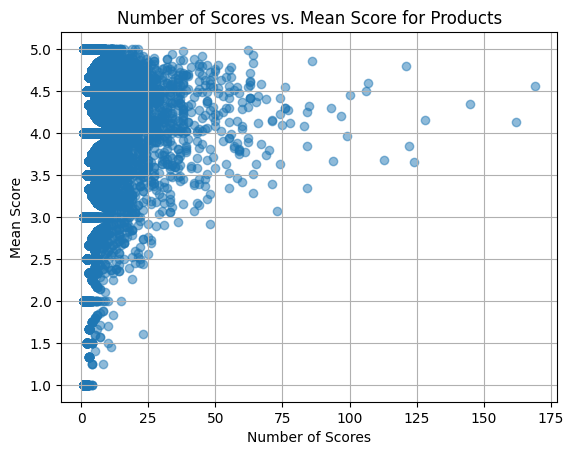

In [83]:
product_stats = df.groupby('ProductId').agg({'Score': ['count', 'mean']})

# Rename the columns for clarity
product_stats.columns = ['Count', 'MeanScore']

# Create a scatter plot
plt.scatter(product_stats['Count'], product_stats['MeanScore'], alpha=0.5)
plt.title("Number of Scores vs. Mean Score for Products")
plt.xlabel("Number of Scores")
plt.ylabel("Mean Score")
plt.grid(True)
plt.show()

In [84]:
prod_ct = df.groupby('ProductId')['ProductId'].transform('count')
df['Prod_Ct'] = prod_ct #adding a new col to the df with the count of each product

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from xgboost import XGBRegressor

df['Summary'] = df['Summary'].astype(str) #want to be able to process the language
df['Text'] = df['Text'].astype(str) #want to be able to process the language
df.drop('UserId', axis=1, inplace=True) #no correlation

In [86]:
import pandas as pd
new_df = df.sample(n=40000, random_state=42)
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4)) #code from class repo to translate the text cols to vectors
X = vectorizer.fit_transform(new_df['Summary'] + ' ' + new_df['Text'])
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

In [87]:
new_df.head()

,Id,ProductId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,Helpful,Prod_Ct
108883,1141561,B0013ERFFU,2,5,2008-06-29,Lighthearted comedy.,A light hearted comedy with a fantastic group ...,5.0,0.400000,5
99136,844401,B0002S65KY,3,4,2004-11-06,A well-done drama,"I really liked the movie, but it may be incomp...",4.0,0.750000,2
14854,693324,B0000633ZP,2,3,2007-11-30,"Star Wars Episode II, Attack of the Clones","Wow, how could such a great series produce som...",2.0,0.666667,69
77695,14403,0767818040,27,30,2006-10-13,Voyeurism and Hitchcock a-go-go!,"In the early 1980s, Brian De Palma made two mo...",4.0,0.900000,6
40328,288949,6301982746,4,4,2008-07-24,"As far as I'm concerned, this movie never happ...","As a Rocky aficionado, this movie disappoints ...",2.0,1.000000,14


In [88]:
from scipy.sparse import hstack
helpful_sparse = new_df['Helpful'].values.reshape(-1, 1)
prod_ct_sparse = new_df['Prod_Ct'].values.reshape(-1, 1)

#adding features to the feature matrix X_mat
X_mat = hstack((X_scaled, helpful_sparse, prod_ct_sparse))

#Create and train XGBRegressor
model1 = XGBRegressor(n_jobs=-1, n_estimators = 100, learning_rate=0.1)

#model1.fit(X_mat, new_df['Score'])

In [89]:
model1.fit(X_mat, new_df['Score'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [90]:
df_og = pd.read_csv("train_og.csv")
df_og['Helpful'] = df_og['HelpfulnessNumerator']/ df_og['HelpfulnessDenominator']
prod_ct_2 = df_og.groupby('ProductId')['ProductId'].transform('count')
df_og['Prod_Ct'] = prod_ct_2 
test_set = df_og.merge(test_x, on=['Id']) #using merge bc test set alone wasnt working
#adding a new col to the df with the count of each product

In [91]:
test_set['Summary'] = test_set['Summary'].astype(str)
test_set['Text'] = test_set['Text'].astype(str)
test_set['Helpful'] = test_set['Helpful'].fillna(0)
ts_X=vectorizer.transform(test_set['Summary'] + ' ' + test_set['Text'])
ts_X_scaled = scaler.fit_transform(ts_X)

In [92]:
hf_sparse_ts = test_set['Helpful'].values.reshape(-1, 1)
prod_sparse_ts = test_set['Prod_Ct'].values.reshape(-1, 1)

#adding features to the feature matrix X_mat
X_mat_ts = hstack((ts_X_scaled, hf_sparse_ts, prod_sparse_ts))
test_set['Score'] = model1.predict(X_mat_ts).round()
test_set= test_set.replace(to_replace=0.0, value=1.0)

submission = test_set[['Id', 'Score']]
submission.to_csv("submission_xgboost.csv", index=False)

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

rf = RandomForestClassifier()
rf.fit(X_mat, new_df['Score'])

RandomForestClassifier()

In [94]:
test_set['ScoreRF'] = rf.predict(X_mat_ts).round()
test_set= test_set.replace(to_replace=0.0, value=1.0)
submission_rf = test_set[['Id', 'ScoreRF']]
submission_rf.to_csv("submission_rf.csv", index =False)

In [96]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators=100, learning_rate=1.0)
ada.fit(X_mat, new_df['Score'])

AdaBoostRegressor(n_estimators=100)

In [97]:
test_set['ScoreAda'] = ada.predict(X_mat_ts).round()
test_set= test_set.replace(to_replace=0.0, value=1.0)
submission_ada = test_set[['Id', 'ScoreAda']]
submission_ada.to_csv("submission_ada.csv", index =False)

In [101]:
from imblearn.over_sampling import RandomOverSampler 
ros = RandomOverSampler(random_state=42)
resampled_x, resampled_y = ros.fit_resample(X_mat, new_df['Score']) #oversamples the data bc it is highly skewed


In [102]:
XGBoost_os = XGBRegressor(n_jobs=-1, n_estimators = 100, learning_rate=0.1)
XGBoost_os.fit(X_mat, new_df['Score'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [106]:
test_set['ScoreXGB_OS'] = XGBoost_os.predict(X_mat_ts).round()
test_set= test_set.replace(to_replace=0.0, value=1.0)
test_set['DiffOS'] = test_set['Score'] - test_set['ScoreXGB_OS'] #want a new col to see the diff in scores when I oversampled
submission = test_set[['Id', 'ScoreXGB_OS', 'DiffOS']]
submission.to_csv("submission_xgboost_oversampled.csv", index=False)

In [114]:
#computing accuracy of best model
new_df2 = df.sample(n=100000, random_state=42)
new_df2['Summary'] = new_df2['Summary'].astype(str)
new_df2['Text'] = new_df2['Text'].astype(str)
new_df2['Helpful'] = new_df2['Helpful'].fillna(0)
train_X_vect = vectorizer.fit_transform(new_df2['Summary'] + ' ' + new_df2['Text'])
train_X_scaled = scaler.fit_transform(train_X_vect)
helpful_sparse_tr = new_df2['Helpful'].values.reshape(-1, 1)
prod_ct_sparse_tr = new_df2['Prod_Ct'].values.reshape(-1, 1)

#adding features to the feature matrix X_mat
X_mat_tr = hstack((train_X_scaled, helpful_sparse_tr, prod_ct_sparse_tr))

In [115]:
new_df2['Pred_Score'] = model1.predict(X_mat_tr).round()
new_df2['Pred_Score'] = new_df2['Pred_Score'].replace(0, 1)

ValueError: Feature shape mismatch, expected: 294784, got 414411